## TestModels
This script:
- Reads in the dataframe containing the per-LSOA summary info (e.g. mean/max/min embedding, mean/max/min embedding per category , % of images in each category in each LSOA)
- Compares model performance:
    - When using mean/max/min embedding
    - When including the variables recording the % of images in each category
- Properly fits and tests model using cross-validation

In [16]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*glibc.*")

import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import json
import multiprocessing

data_dir = os.path.join("../../../../data/embeddings/")
imd_file = os.path.join("../../../../", "data", "imd", "File_2_-_IoD2025_Domains_of_Deprivation.xlsx")

var_to_predict = 'imd_rank'

def evaluate_imd_model(y_true, y_pred, column,num_in_class, num_lsoas, plot=True, plot_collectively = False, ax=False ):

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Spearman_rank_corr': spearman_corr}

    # Print metrics
    #print("Model evaluation metrics:")
    #for k, v in metrics.items():
    #    print(f"{k}: {v:.3f}")

    # Scatter plot
    if plot:
        plt.figure(figsize=(6,6))
        plt.scatter(y_true, y_pred, alpha=0.7)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        plt.xlabel(f"True {column}")
        plt.ylabel(f"Predicted {column}")
        plt.title(f"{column}")
        plt.grid(True)
        plt.show()

    # Scatter plot
    if plot_collectively:
        ax.scatter(y_true, y_pred, alpha=0.7)
        ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        ax.set_xlabel(f"True")
        ax.set_ylabel(f"Predicted")
        ax.set_title(f"{column}: \n{num_in_class} images\n {num_lsoas} LSOAs", fontsize=15)
        ax.grid(True)
        ax.text(
            0.01, 0.99,  # x=1% from left, y=99% from bottom
            f'R² = {r2:.2f}, RMSE = {rmse:.0f}',
            transform=ax.transAxes,  # use axes coordinates
            fontsize=12,
            verticalalignment='top',  # anchor to top so it doesn’t go outside
            horizontalalignment='left')
    
    return metrics

### Get imd data

In [2]:
imd = pd.read_excel(imd_file, sheet_name="IoD2025 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2021)": "LSOA21CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

### Get embedding data

In [3]:
file_ending = 'planninguseclasses' # 'planninguseclasses' # 'refined_again'
categories_dict = {'planninguseclasses':['C – Accommodation', 'B – Industrial / Storage', 'E – Commercial / Business / Service', 
                       'F – Local Community / Learning'],
                  'userdefinedclasses': ['office', 'single_house', 'urban_street', 'shops_and_cafes', 'car',  'park', 
                         'cucumber',  'highway', 'residential_street', 'industrial', 'road']}
category_pct_cols = categories_dict[file_ending]

In [43]:
big_summary_df = pd.read_pickle(data_dir +f"embedding_summaries/big_summary_df_{file_ending}.pkl")
big_summary_df_with_imd = pd.merge(left=big_summary_df, right=imd, on="LSOA21CD")
big_summary_df_with_imd['imd_rerank'] = big_summary_df_with_imd['imd_rank'].rank(method='first').astype(int)

# 1. Using overall mean/max/median embedding per LSOA
Test the performance of a random forest model with a 80-20% train-test split.  
Test performance using the mean/max/median embedding as the predictor variables.

max
mean
median


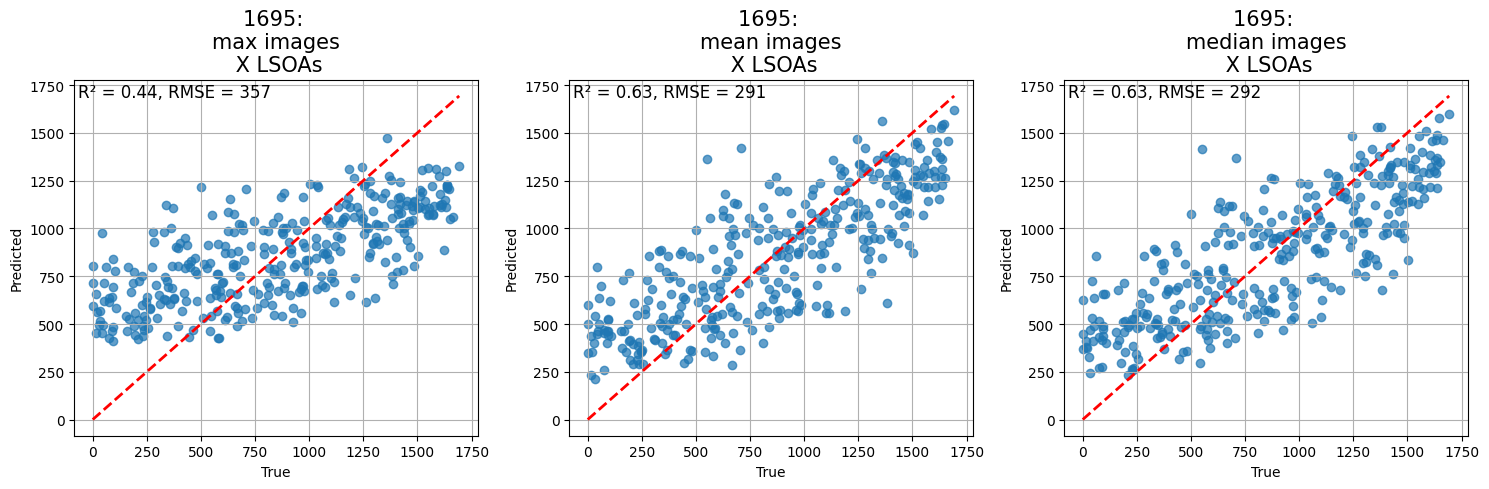

In [46]:
fig, axs=plt.subplots(ncols=3, nrows=1, figsize=(15,5))
axs=axs.flatten()
i=0
for metric in ['max', 'mean', 'median']:
    print(metric)
    X = np.stack(big_summary_df_with_imd[f"overall_{metric}"].values)     
    y = big_summary_df_with_imd['imd_rerank'].values

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit a model (Random Forest Regressor example)
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf.predict(X_test)

    # Usage example:
    metrics = evaluate_imd_model(y_test, y_pred, len(big_summary_df_with_imd), metric, 'X', plot=False, plot_collectively =True, ax=axs[i])

    i=i+1
fig.tight_layout()

# 2. Testing whether % in categories improves model performance
Test the performance of a random forest model with a 80-20% train-test split.  
Test performance using:  
    - Just the median embedding.   
    - The percentage of images in each category.  
    - The median embedding plus the percentage of images in each category.   

### Model just using embeddings

In [ ]:
# define predictor and response variables
X_embed = np.stack(big_summary_df_with_imd["overall_median"].values)
y = big_summary_df_with_imd["imd_rerank"].values

# Define train/test data
X_train_e, X_test_e, y_train, y_test = train_test_split(X_embed, y, test_size=0.2, random_state=42)

# Fit and run model
rf_embed = RandomForestRegressor(n_estimators=200, random_state=42)
rf_embed.fit(X_train_e, y_train)

# Predict
y_pred_embed = rf_embed.predict(X_test_e)
metrics_embed = evaluate_imd_model(y_test, y_pred_embed, 'imd_rerank', plot=False, plot_collectively=False, ax=False)

### Model just using percentages

In [ ]:
# define predictor and response variables
X_pct = big_summary_df_with_imd[category_pct_cols].values
y = big_summary_df_with_imd["imd_rerank"].values

# Define train/test data
X_train_p, X_test_p, y_train, y_test = train_test_split(X_pct, y, test_size=0.2, random_state=42)

# Fit model
rf_pct = RandomForestRegressor(n_estimators=200, random_state=42)
rf_pct.fit(X_train_p, y_train)

# Predict
y_pred_pct = rf_pct.predict(X_test_p)

# Evaluate
metrics_pct = evaluate_imd_model(y_test, y_pred_pct,'imd_rerank', plot=False, plot_collectively=False, ax=False)

### Model using embeddings + precentages

In [ ]:
# define predictor and response variables
X_full = np.hstack([X_embed, X_pct])

# Define train/test data
X_train_f, X_test_f, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Fit and run model
rf_full = RandomForestRegressor(n_estimators=200, random_state=42)
rf_full.fit(X_train_f, y_train)

# Predict
y_pred_full = rf_full.predict(X_test_f)
metrics_full = evaluate_imd_model(y_test, y_pred_full, 'imd_rerank', plot=False, plot_collectively=False, ax=False)

### Compare performance

In [ ]:
fig, axs=plt.subplots(ncols=3, nrows=1, figsize=(15,5))
metrics_embed = evaluate_imd_model(y_test, y_pred_embed, 'Embeddings', plot=False, plot_collectively=True, ax=axs[0])
metrics_pct = evaluate_imd_model(y_test, y_pred_pct,'Category percentages', plot=False, plot_collectively=True, ax=axs[1])
metrics_full = evaluate_imd_model(y_test, y_pred_full, 'Both', plot=False, plot_collectively=True, ax=axs[2])

# Fit model properly
Fit several different models with cross validation and hyper-parameter tuning, in order to work out the best model and parameters.  

SHOULD WE DO THIS FIRST AND THEN USE THE ANSWER IN THE ABOVE TESTS?

In [13]:
# X = np.stack(big_summary_df_with_imd["overall_median"].values)     # shape (n_points, embed_dim)
# y = big_summary_df_with_imd['imd_rerank'].values

# # -------------------------
# # Split data into training and test sets
# # -------------------------
# X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
#     X, y, np.arange(X.shape[0]), test_size=0.2, random_state=42)
# print(f"Training points: {X_train.shape[0]}, Test points: {X_test.shape[0]}")

# # -------------------------
# # Define model pipelines and parameter grids
# # -------------------------
# models = []
# param_grids = []

# # 1. Linear Regression
# pipe_linear = Pipeline([
#     ('scaler', StandardScaler()),
#     ('reg', LinearRegression())])
# models.append(pipe_linear)
# param_grids.append({})

# # 2. Random Forest
# pipe_rf = Pipeline([
#     ('scaler', StandardScaler()),
#     ('reg', RandomForestRegressor(random_state=42))])
# models.append(pipe_rf)
# param_grids.append({
#     'reg__n_estimators': [100, 200],
#     'reg__max_depth': [None, 10, 20]})

# # 4. XGBoost Regressor
# pipe_xgb = Pipeline([
#     ('scaler', StandardScaler()),  # scaling not strictly necessary but fine to keep
#     ('reg', XGBRegressor(
#         objective='reg:squarederror',  # standard regression objective
#         random_state=42,
#         n_jobs=-1,
#         verbosity=0))])
# models.append(pipe_xgb)
# param_grids.append({
#     'reg__n_estimators': [100, 300],
#     'reg__max_depth': [3, 6, 10],
#     'reg__learning_rate': [0.01, 0.1, 0.3],
#     'reg__subsample': [0.8, 1.0]})

# # 3. Neural Network (MLPRegressor)
# pipe_mlp = Pipeline([
#     ('scaler', StandardScaler()),
#     ('reg', MLPRegressor(max_iter=1500,
#                              activation='relu',           # default, works well for embeddings
#     solver='adam',               # stochastic gradient optimizer
#     learning_rate_init=1e-3,     # small learning rate improves convergence on high-dim data
#     early_stopping=True,         # stop automatically if validation score doesn’t improve
#     n_iter_no_change=50,         # patience for early stopping
#     random_state=42,
#     verbose=False))])
# models.append(pipe_mlp)
# param_grids.append({
#     'reg__hidden_layer_sizes': [(100,), (100, 50)],
#     'reg__alpha': [1e-4, 1e-3]})

# # -------------------------
# # Perform cross-validation
# # -------------------------
# best_model = None
# best_score = -np.inf
# best_model_name = None
# best_params = {}

# print("Training models")
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
# ncores = min(multiprocessing.cpu_count() - 1, 100)
# print(f"Using {ncores} cores.")

# for model, param_grid, name in zip(
#     models, param_grids, ["LinearReg", "RandomForest", "XGBoost", "NeuralNet"]):
#     print(f"\nTraining: {name}...")
#     if param_grid:
#         grid = GridSearchCV(model, param_grid, cv=cv, scoring='r2', n_jobs=ncores)
#         grid.fit(X_train, y_train)
#         cv_score = grid.best_score_
#         model_best = grid.best_estimator_
#         params_best = grid.best_params_
#     else:
#         scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
#         cv_score = np.mean(scores)
#         model.fit(X_train, y_train)
#         model_best = model
#         params_best = {}

#     print(f"{name} CV mean R² = {cv_score:.3f} {('(best params: '+str(params_best)+')') if params_best else ''}")

#     # Track the best
#     if cv_score > best_score:
#         best_score = cv_score
#         best_model = model_best
#         best_model_name = name
#         best_params = params_best.copy()

# print(f"\nBest model: {best_model_name} (R² = {best_score:.3f})")
# print(f"Best hyperparameters: {best_params}")

# print(f"Best model from CV: {best_model_name} with R^2 = {best_score:.3f} and params {best_params}")

# # Save the meta-data so the model can be trained on the different domains of deprivation
# best_model_info = {
#     "model_name": best_model_name,
#     "best_score": float(best_score),
#     "best_params": best_params}

# ## ---- SAVE the model ----
# #bundle = {
# #    "model": best_model,                 # the fitted Pipeline
# #    "name": best_model_name,             # e.g., "RandomForest"
# #    "cv_score_r2": float(best_score),    # ensure JSON-safe
# #    "trained_at": datetime.utcnow().isoformat() + "Z",
# #    "sklearn_version": sklearn.__version__
# #}
# #dump(bundle, os.path.join(data_dir, "5-imd_best_model_bundle.joblib", compress=3)
# #print("Saved to best_model_bundle.joblib")

Training points: 1356, Test points: 339
Training models
Using 31 cores.

Training: LinearReg...
LinearReg CV mean R² = 0.413 

Training: RandomForest...
RandomForest CV mean R² = 0.619 (best params: {'reg__max_depth': 10, 'reg__n_estimators': 200})

Training: XGBoost...


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGB

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGB

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


XGBoost CV mean R² = 0.671 (best params: {'reg__learning_rate': 0.1, 'reg__max_depth': 3, 'reg__n_estimators': 300, 'reg__subsample': 0.8})

Training: NeuralNet...


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


NeuralNet CV mean R² = 0.614 (best params: {'reg__alpha': 0.0001, 'reg__hidden_layer_sizes': (100, 50)})

Best model: XGBoost (R² = 0.671)
Best hyperparameters: {'reg__learning_rate': 0.1, 'reg__max_depth': 3, 'reg__n_estimators': 300, 'reg__subsample': 0.8}
Best model from CV: XGBoost with R^2 = 0.671 and params {'reg__learning_rate': 0.1, 'reg__max_depth': 3, 'reg__n_estimators': 300, 'reg__subsample': 0.8}


In [ ]:
# with open(os.path.join(data_dir, "5-imd_best_model_info_CLIP.json"), "w") as f:
#     json.dump(best_model_info, f, indent=2)
# print(f"Cached model info:", best_model_info)